In [1]:
from libraries import lib
from libraries.NeuralStates import *
import qutip as qt
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 5
J = 1
Gamma = 1

In [3]:
h = lib.TFIM_hamiltonian(N, J, Gamma)
h

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-5. -1. -1. ...  0.  0.  0.]
 [-1. -1.  0. ...  0.  0.  0.]
 [-1.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0. -1.]
 [ 0.  0.  0. ...  0. -1. -1.]
 [ 0.  0.  0. ... -1. -1. -5.]]

In [4]:
h[0][0]

array([-5.+0.j, -1.+0.j, -1.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j])

In [5]:
h[3][0][1]

np.complex128(-1+0j)

In [6]:
for r in range(N):
    for c in range(N):
        print(h[r][0][c] == lib.calc_H_elem(N, J, Gamma, r, c))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [10]:
# test given all states are sampled
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
input = lib.generate_input_torch(N)
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])

In [11]:
lib.train_model_to_gs(model, 
                      lambda model : model(input), 
                      lambda nn_output : lib.TFIM_expectation_from_torch(nn_output, (N, J, Gamma), amp_phase), 
                      33, data_rate = 1)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [-4.985903263092041,
  -4.99866247177124,
  -4.999605178833008,
  -4.9999098777771,
  -5.000131607055664,
  -5.000327110290527,
  -5.000511646270752,
  -5.000689506530762,
  -5.0008673667907715,
  -5.001045227050781,
  -5.001232147216797,
  -5.001426696777344,
  -5.001631259918213,
  -5.001852512359619,
  -5.0020904541015625,
  -5.002352714538574,
  -5.002641677856445,
  -5.002965927124023,
  -5.003332138061523,
  -5.003753185272217,
  -5.004238605499268,
  -5.004809856414795,
  -5.005487442016602,
  -5.0063066482543945,
  -5.007311820983887,
  -5.008565425872803,
  -5.010165691375732,
  -5.012249946594238,
  -5.015038967132568,
  -5.0188822746276855,
  -5.024363040924072,
  -5.032504558563232,
  -5.0451979637146])

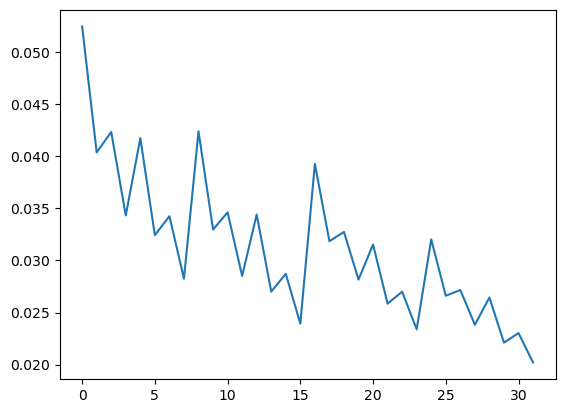

In [12]:
model_state = lib.model_to_ground_state(model, lib.generate_input_torch(N), amp_phase)
model_state = np.squeeze(model_state.full())
plt.plot([n for n in range(0, 2 ** N)], np.abs(model_state) ** 2)
plt.show()

In [13]:
ustate = UniformNeuralState(N, model, amp_phase, 2 ** N)

In [14]:
SparseStateVector.TFIM_expectation_from_sparse(ustate, N, J, Gamma)

tensor(-5.0662, grad_fn=<SelectBackward0>)

In [15]:
lib.TFIM_expectation_using_locals(ustate, N, J, Gamma, model, amp_phase)

tensor(-5.0662, grad_fn=<SelectBackward0>)

In [16]:
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [17]:
num_samples = 9
ustate = UniformNeuralState(N, model, amp_phase, num_samples)
mhstate = MHNeuralState(N, model, amp_phase, 
                        lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)

In [18]:
print(SparseStateVector.TFIM_expectation_from_sparse(mhstate, N, J, Gamma).item())
print(SparseStateVector.TFIM_expectation_from_sparse(ustate, N, J, Gamma).item())
print(lib.TFIM_expectation_using_locals(mhstate, N, J, Gamma, model, amp_phase).item())
print(lib.TFIM_expectation_using_locals(ustate, N, J, Gamma, model, amp_phase).item())

-1.5128144025802612
-1.2044728994369507
-4.916638374328613
-4.973937034606934


In [19]:
lib.TFIM_expectation_using_locals(mhstate, N, J, Gamma, model, amp_phase)

tensor(-4.9166, grad_fn=<SelectBackward0>)

In [20]:
mh_sparse = []
mh_local = []
u_sparse = []
u_local = []
num_trials = 15
for num_samples in range(1, 32):
    mh_sparse_data = []
    mh_local_data = []
    u_sparse_data = []
    u_local_data = []
    for _ in range(num_trials):
        mhstate = MHNeuralState(N, model, amp_phase,
                                lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
        ustate = UniformNeuralState(N, model, amp_phase, num_samples)
        mh_sparse_data.append(SparseStateVector.TFIM_expectation_from_sparse(mhstate, N, J, Gamma).item())
        mh_local_data.append(lib.TFIM_expectation_using_locals(mhstate, N, J, Gamma, model, amp_phase).item())
        u_sparse_data.append(SparseStateVector.TFIM_expectation_from_sparse(ustate, N, J, Gamma).item())
        u_local_data.append(lib.TFIM_expectation_using_locals(ustate, N, J, Gamma, model, amp_phase).item())
    mh_sparse.append([np.mean(mh_sparse_data), np.std(mh_sparse_data)])
    mh_local.append([np.mean(mh_local_data), np.std(mh_local_data)])
    u_sparse.append([np.mean(u_sparse_data), np.std(u_sparse_data)])
    u_local.append([np.mean(u_local_data), np.std(u_local_data)])
data = [mh_sparse, mh_local, u_sparse, u_local]
labels = ['mh-sparse', 'mh-locals', 'u-sparse', 'u-local']
data = np.array(data)

In [21]:
labels = ['mh-sparse', 'mh-locals', 'u-sparse', 'u-local']
colors = ['blue', 'orange', 'red', 'green']

In [22]:
data.shape

(4, 31, 2)

In [23]:
data[0, :, 0]

array([-0.46666671, -1.15508137, -1.20018905, -1.39598719, -1.76141239,
       -1.92839901, -2.07201665, -2.08803215, -2.10018488, -2.01386982,
       -2.44336536, -2.83748768, -2.29186236, -2.54775247, -2.75722556,
       -2.82733448, -2.80669788, -2.99466072, -2.71294223, -2.54695041,
       -3.08194286, -2.93461892, -3.20615233, -3.12259363, -2.86322821,
       -3.08800619, -3.25588001, -3.43517257, -3.57131894, -3.00474308,
       -3.52928602])

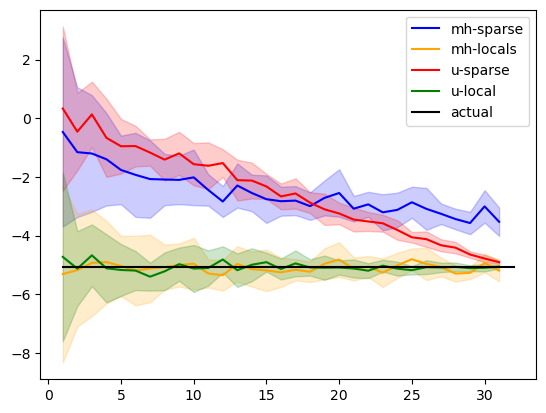

In [24]:
x = [n for n in range(1, 32)]
for i in range(len(labels)):
    plt.plot(x, data[i, :, 0], color = colors[i], label = labels[i])
    plt.fill_between(x, data[i, :, 0] - data[i, :, 1], data[i, :, 0] + data[i, :, 1], color = colors[i], alpha = 0.2)
actual = UniformNeuralState(N, model, amp_phase, 2 ** N).TFIM_expectation_from_sparse(N, J, Gamma).item()
plt.plot([1, 32], [actual, actual], color = 'black', label = 'actual')
plt.legend(loc = 'best')
plt.show()

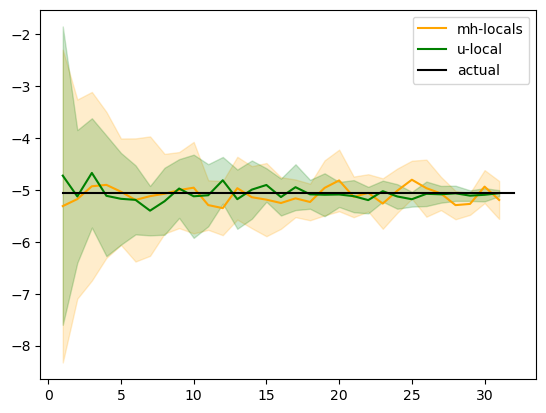

In [25]:
x = [n for n in range(1, 32)]
for i in [1, 3]:
    plt.plot(x, data[i, :, 0], color = colors[i], label = labels[i])
    plt.fill_between(x, data[i, :, 0] - data[i, :, 1], data[i, :, 0] + data[i, :, 1], color = colors[i], alpha = 0.2)
actual = UniformNeuralState(N, model, amp_phase, 2 ** N).TFIM_expectation_from_sparse(N, J, Gamma).item()
plt.plot([1, 32], [actual, actual], color = 'black', label = 'actual')
plt.legend(loc = 'best')
plt.show()

In [26]:
data[1, :, 1]

array([3.01324295, 1.91888355, 1.81732422, 1.40611813, 1.02555925,
       1.18672031, 1.15073259, 0.76791597, 0.73298466, 0.88139363,
       0.47751509, 0.52066208, 0.60494633, 0.59849581, 0.70534317,
       0.49731702, 0.36283282, 0.35236426, 0.53050161, 0.59362778,
       0.3917822 , 0.35918494, 0.48638699, 0.42689554, 0.36656219,
       0.5499893 , 0.32044201, 0.27253119, 0.21062232, 0.31787541,
       0.36595887])

In [27]:
data[3, :, 1]

array([2.87421839, 1.27821657, 1.0530781 , 1.16223936, 0.88379935,
       0.66557346, 0.47577283, 0.64552126, 0.56622044, 0.8021496 ,
       0.59842994, 0.44909851, 0.57090487, 0.56128818, 0.32179485,
       0.35602808, 0.44155627, 0.27821992, 0.41349505, 0.24116972,
       0.30923047, 0.25559849, 0.20281968, 0.23652848, 0.1423122 ,
       0.23628111, 0.1616226 , 0.14626325, 0.10190242, 0.12739356,
       0.05779973])

In [28]:
# test given all states are sampled
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
input = lib.generate_input_torch(N)
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])

In [29]:
lib.train_model_to_gs(model, 
                      lambda model : model(input), 
                      lambda nn_output : lib.TFIM_expectation_from_torch(nn_output, (N, J, Gamma), amp_phase), 
                      100, data_rate = 1)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 [-4.985509395599365,
  -4.992923736572266,
  -4.996018886566162,
  -4.997648239135742,
  -4.998637676239014,
  -4.999333381652832,
  -4.999894142150879,
  -5.000405788421631,
  -5.000911712646484,
  -5.001443862915039,
  -5.002032279968262,
  -5.002706050872803,
  -5.0035080909729,
  -5.004496097564697,
  -5.005761623382568,
  -5.007441520690918,
  -5.009778022766113,
  -5.013187885284424,
  -5.0184545516

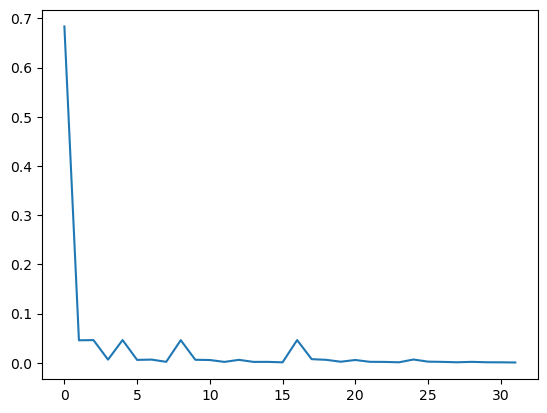

In [30]:
model_state = lib.model_to_ground_state(model, lib.generate_input_torch(N), amp_phase)
model_state = np.squeeze(model_state.full())
plt.plot([n for n in range(0, 2 ** N)], np.abs(model_state) ** 2)
plt.show()

In [31]:
mh_sparse = []
mh_local = []
u_sparse = []
u_local = []
num_trials = 15
for num_samples in range(1, 32):
    mh_sparse_data = []
    mh_local_data = []
    u_sparse_data = []
    u_local_data = []
    for _ in range(num_trials):
        mhstate = MHNeuralState(N, model, amp_phase,
                                lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
        ustate = UniformNeuralState(N, model, amp_phase, num_samples)
        mh_sparse_data.append(SparseStateVector.TFIM_expectation_from_sparse(mhstate, N, J, Gamma).item())
        mh_local_data.append(lib.TFIM_expectation_using_locals(mhstate, N, J, Gamma, model, amp_phase).item())
        u_sparse_data.append(SparseStateVector.TFIM_expectation_from_sparse(ustate, N, J, Gamma).item())
        u_local_data.append(lib.TFIM_expectation_using_locals(ustate, N, J, Gamma, model, amp_phase).item())
    mh_sparse.append([np.mean(mh_sparse_data), np.std(mh_sparse_data)])
    mh_local.append([np.mean(mh_local_data), np.std(mh_local_data)])
    u_sparse.append([np.mean(u_sparse_data), np.std(u_sparse_data)])
    u_local.append([np.mean(u_local_data), np.std(u_local_data)])
data = [mh_sparse, mh_local, u_sparse, u_local]
labels = ['mh-sparse', 'mh-locals', 'u-sparse', 'u-local']
data = np.array(data)

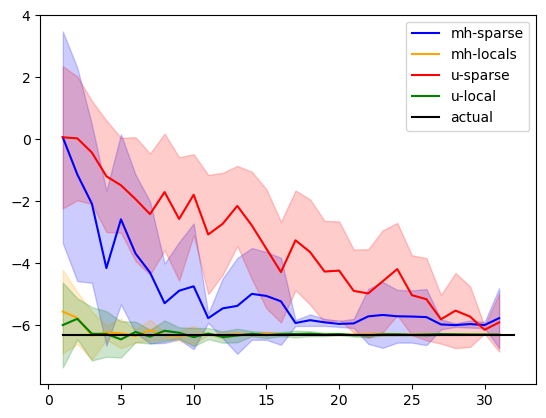

In [32]:
x = [n for n in range(1, 32)]
for i in range(len(labels)):
    plt.plot(x, data[i, :, 0], color = colors[i], label = labels[i])
    plt.fill_between(x, data[i, :, 0] - data[i, :, 1], data[i, :, 0] + data[i, :, 1], color = colors[i], alpha = 0.2)
actual = UniformNeuralState(N, model, amp_phase, 2 ** N).TFIM_expectation_from_sparse(N, J, Gamma).item()
plt.plot([1, 32], [actual, actual], color = 'black', label = 'actual')
plt.legend(loc = 'best')
plt.show()

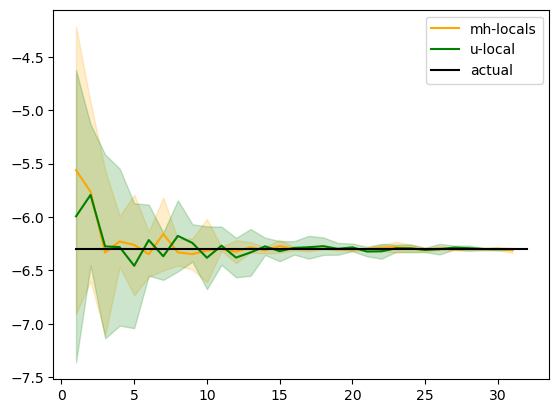

In [33]:
x = [n for n in range(1, 32)]
for i in [1, 3]:
    plt.plot(x, data[i, :, 0], color = colors[i], label = labels[i])
    plt.fill_between(x, data[i, :, 0] - data[i, :, 1], data[i, :, 0] + data[i, :, 1], color = colors[i], alpha = 0.2)
actual = UniformNeuralState(N, model, amp_phase, 2 ** N).TFIM_expectation_from_sparse(N, J, Gamma).item()
plt.plot([1, 32], [actual, actual], color = 'black', label = 'actual')
plt.legend(loc = 'best')
plt.show()

In [34]:
data[1, :, 1]

array([1.34639793, 0.8374567 , 0.77493928, 0.2368645 , 0.4712082 ,
       0.21223559, 0.34214816, 0.12244361, 0.14627963, 0.29619181,
       0.0184321 , 0.10739256, 0.04877697, 0.02970142, 0.06145198,
       0.01498275, 0.01761544, 0.00664051, 0.01197147, 0.01361385,
       0.01144326, 0.02720457, 0.05220435, 0.03079029, 0.01779252,
       0.01645263, 0.01059582, 0.01143259, 0.01127016, 0.01648262,
       0.02397125])

In [35]:
data[3, :, 1]

array([1.36993594, 0.66107528, 0.86179168, 0.7359364 , 0.58496018,
       0.33282598, 0.22157055, 0.333443  , 0.17529189, 0.29404932,
       0.17909344, 0.18499603, 0.21926165, 0.08128919, 0.09434449,
       0.06305804, 0.10707232, 0.08197901, 0.05540684, 0.03614537,
       0.04432481, 0.06963848, 0.03330469, 0.03723784, 0.02051397,
       0.04970025, 0.01861907, 0.02449065, 0.00981988, 0.00968276,
       0.00695183])

In [36]:
N = 6
J = 1
Gamma = 1

In [37]:
h = lib.TFIM_hamiltonian(N, J, Gamma)
min_energy = h.eigenstates()[0][0]
min_energy

np.float64(-7.727406610312534)

In [50]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
input = lib.generate_input_torch(N)

In [51]:
num_samples = 30
num_epochs = 500 + 1
data_rate = 1

In [52]:
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
print(loss_data[-1])
print(min(loss_data))

-6.878446578979492
-9.238568305969238


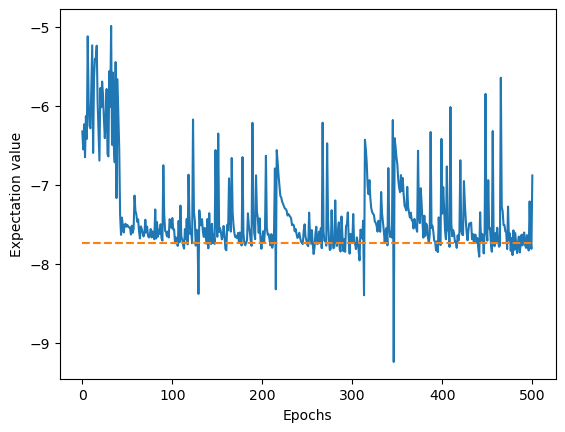

In [53]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [56]:
num_samples = 20
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
print(loss_data[-1])
print(min(loss_data))

nan
-3786.3876953125


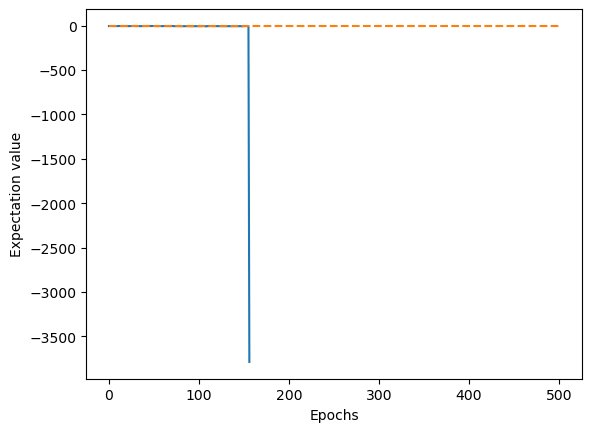

In [57]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [58]:
Gamma = 0.1

In [59]:
num_samples = 30

In [60]:
h = lib.TFIM_hamiltonian(N, J, Gamma)
min_energy = h.eigenstates()[0][0]
min_energy

np.float64(-6.015009643654403)

In [61]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
input = lib.generate_input_torch(N)

In [62]:
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
print(loss_data[-1])
print(min(loss_data))

-6.010002613067627
-6.9210052490234375


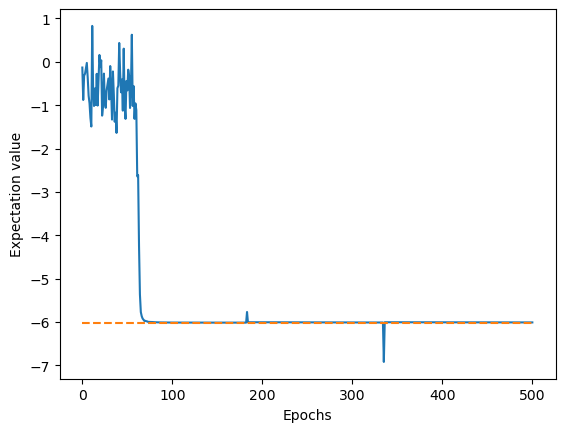

In [63]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [64]:
num_samples = 20
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
print(loss_data[-1])
print(min(loss_data))

nan
-20157.912109375


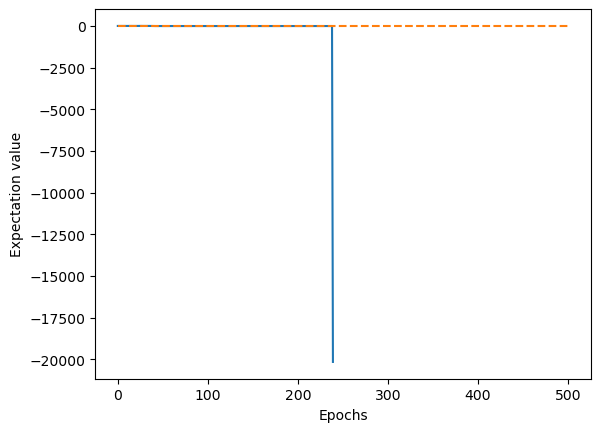

In [65]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [66]:
Gamma = 10

In [67]:
num_samples = 10

In [68]:
h = lib.TFIM_hamiltonian(N, J, Gamma)
min_energy = h.eigenstates()[0][0]
min_energy

np.float64(-60.15009643654393)

In [69]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
input = lib.generate_input_torch(N)

In [70]:
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
print(loss_data[-1])
print(min(loss_data))

-58.88882827758789
-62.90007781982422


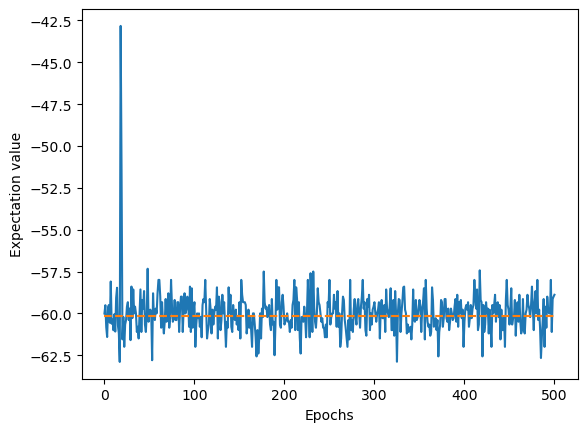

In [71]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [84]:
num_samples = 8
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
print(loss_data[-1])
print(min(loss_data))

-60.49995040893555
-62.80889892578125


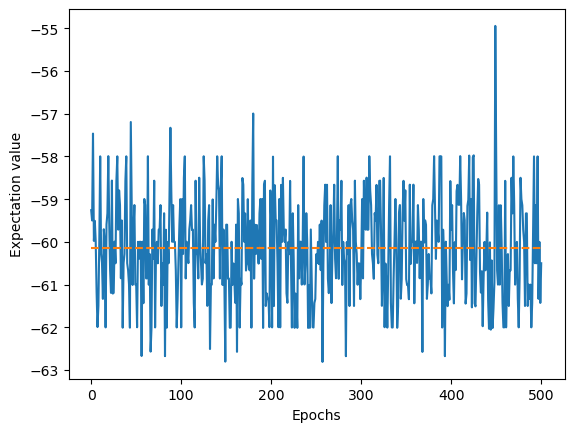

In [ ]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [88]:
N = 10
J = 1
Gamma = 10

In [ ]:
num_samples = 50

In [ ]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
    if epoch % 50 == 0:
        print(epoch, loss)
print(loss_data[-1])
print(min(loss_data))

0 tensor(-100.6104, grad_fn=<SelectBackward0>)
50 tensor(-99.9130, grad_fn=<SelectBackward0>)
100 tensor(-98.5128, grad_fn=<SelectBackward0>)
150 tensor(-100.5115, grad_fn=<SelectBackward0>)
200 tensor(-99.8182, grad_fn=<SelectBackward0>)
250 tensor(-100.0950, grad_fn=<SelectBackward0>)
300 tensor(-99.7145, grad_fn=<SelectBackward0>)
350 tensor(-101.6578, grad_fn=<SelectBackward0>)
400 tensor(-100.9097, grad_fn=<SelectBackward0>)
450 tensor(-99.6747, grad_fn=<SelectBackward0>)
500 tensor(-100.1000, grad_fn=<SelectBackward0>)
-100.10000610351562
-102.35318756103516


In [92]:
h = lib.TFIM_hamiltonian(N, J, Gamma)
min_energy = h.eigenstates()[0][0]
min_energy

np.float64(-100.25015664234304)

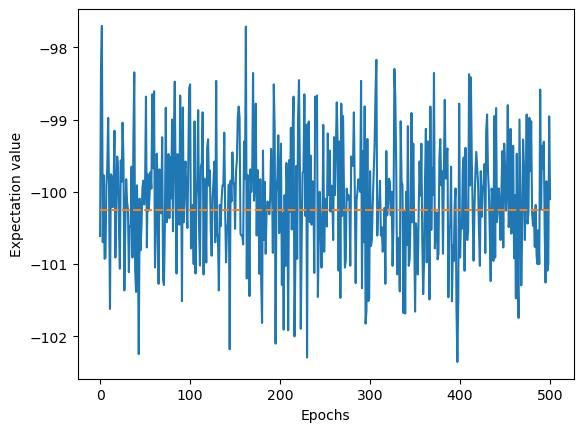

In [93]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [94]:
Gamma = 1

In [95]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
    if epoch % 50 == 0:
        print(epoch, loss)
print(loss_data[-1])
print(min(loss_data))

0 tensor(-9.8164, grad_fn=<SelectBackward0>)
50 tensor(-9.6007, grad_fn=<SelectBackward0>)
100 tensor(-9.6009, grad_fn=<SelectBackward0>)
150 tensor(-11.3010, grad_fn=<SelectBackward0>)
200 tensor(-9.8387, grad_fn=<SelectBackward0>)
250 tensor(-10.2378, grad_fn=<SelectBackward0>)
300 tensor(-9.6709, grad_fn=<SelectBackward0>)
350 tensor(-10.6062, grad_fn=<SelectBackward0>)
400 tensor(-12.8890, grad_fn=<SelectBackward0>)
450 tensor(-10.4801, grad_fn=<SelectBackward0>)
500 tensor(-10.1776, grad_fn=<SelectBackward0>)
-10.177565574645996
-13.620949745178223


In [96]:
h = lib.TFIM_hamiltonian(N, J, Gamma)
min_energy = h.eigenstates()[0][0]
min_energy

np.float64(-12.784906442999324)

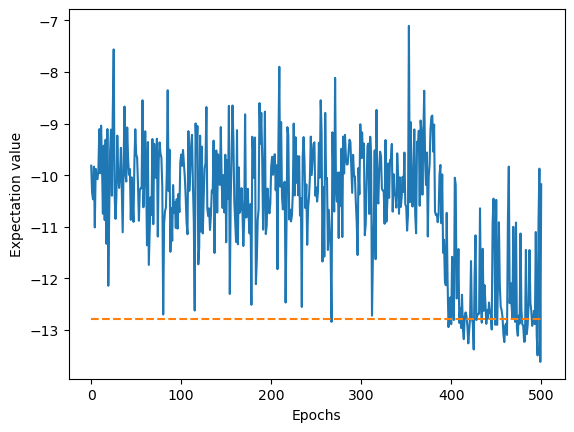

In [97]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [109]:
Gamma = 0.1

In [110]:
h = lib.TFIM_hamiltonian(N, J, Gamma)
min_energy = h.eigenstates()[0][0]
min_energy

np.float64(-10.025015664234315)

In [111]:
num_samples = 50

In [112]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
    if epoch % 50 == 0:
        print(epoch, loss)
print(loss_data[-1])
print(min(loss_data))

0 tensor(-3.0721, grad_fn=<SelectBackward0>)
50 tensor(-10.0214, grad_fn=<SelectBackward0>)
100 tensor(-10.0249, grad_fn=<SelectBackward0>)
150 tensor(-10.0250, grad_fn=<SelectBackward0>)
200 tensor(-10.0250, grad_fn=<SelectBackward0>)
250 tensor(-10.0250, grad_fn=<SelectBackward0>)
300 tensor(-10.0251, grad_fn=<SelectBackward0>)
350 tensor(-10.0250, grad_fn=<SelectBackward0>)
400 tensor(-10.0250, grad_fn=<SelectBackward0>)
450 tensor(-10.0250, grad_fn=<SelectBackward0>)
500 tensor(-10.0250, grad_fn=<SelectBackward0>)
-10.025042533874512
-10.02660846710205


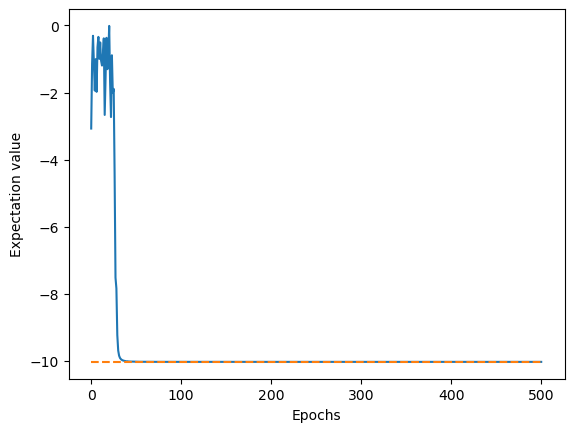

In [113]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [124]:
num_samples = 50

In [125]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, amp_phase, 
                                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
                                                           N, J, Gamma, model, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)
    if epoch % 50 == 0:
        print(epoch, loss)
print(loss_data[-1])
print(min(loss_data))

0 tensor(-2.2831, grad_fn=<SelectBackward0>)
50 tensor(-10.0072, grad_fn=<SelectBackward0>)
100 tensor(-10.0098, grad_fn=<SelectBackward0>)
150 tensor(-10.0107, grad_fn=<SelectBackward0>)
200 tensor(nan, grad_fn=<SelectBackward0>)
250 tensor(nan, grad_fn=<SelectBackward0>)
300 tensor(nan, grad_fn=<SelectBackward0>)
350 tensor(nan, grad_fn=<SelectBackward0>)
400 tensor(nan, grad_fn=<SelectBackward0>)
450 tensor(nan, grad_fn=<SelectBackward0>)
500 tensor(nan, grad_fn=<SelectBackward0>)
nan
-505.0155334472656


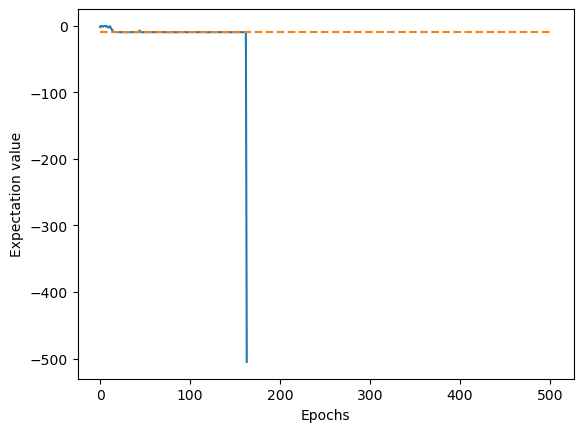

In [126]:
plt.plot(epochs, loss_data)
plt.plot([0, 501], [min_energy] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()